### DenseNet-121

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Training hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4

# CIFAR-100 has 100 classes
num_classes = 100

# Path to save model
model_save_path = './densenet121_cifar100.pth'

In [3]:
# CIFAR-100 normalization statistics
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, 
                                  download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False,
                                download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

# Get class names
class_names = train_dataset.classes
print(f"Dataset loaded: {len(train_dataset)} training samples, {len(test_dataset)} test samples")

Files already downloaded and verified
Files already downloaded and verified
Dataset loaded: 50000 training samples, 10000 test samples


In [4]:
def get_densenet121_model(num_classes=100):
    # Load the pretrained DenseNet-121 model
    model = models.densenet121(weights='IMAGENET1K_V1')
    
    # Replace the final classifier layer to match CIFAR-100's 100 classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    
    return model

# Initialize the model
model = get_densenet121_model(num_classes)
model = model.to(device)

# Display model summary
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            loader = dataloaders['train'] if phase == 'train' else dataloaders['val']
            dataset_size = len(dataloaders['train'].dataset) if phase == 'train' else len(dataloaders['val'].dataset)
            
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Adjust learning rate based on validation loss
                scheduler.step(epoch_loss)
                
                # Deep copy the model if it's the best
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [7]:


# Set aside 10% of training data for validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Randomly split the dataset
train_subset, val_subset = random_split(
    train_dataset, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders for the subsets
train_loader = DataLoader(train_subset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size,
                        shuffle=False, num_workers=4, pin_memory=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

print(f"Training set: {len(train_subset)} samples")
print(f"Validation set: {len(val_subset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples


In [8]:
# Train the model
model, history = train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs
)

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/20
----------
train Loss: 2.7656 Acc: 0.3057
val Loss: 2.1891 Acc: 0.4252

Epoch 2/20
----------
train Loss: 1.9370 Acc: 0.4707
val Loss: 1.8984 Acc: 0.4880

Epoch 3/20
----------
train Loss: 1.6836 Acc: 0.5285
val Loss: 1.8060 Acc: 0.5120

Epoch 4/20
----------
train Loss: 1.5125 Acc: 0.5699
val Loss: 1.6933 Acc: 0.5344

Epoch 5/20
----------
train Loss: 1.3940 Acc: 0.5980
val Loss: 1.6102 Acc: 0.5560

Epoch 6/20
----------
train Loss: 1.2940 Acc: 0.6224
val Loss: 1.6560 Acc: 0.5504

Epoch 7/20
----------
train Loss: 1.1992 Acc: 0.6470
val Loss: 1.6293 Acc: 0.5538

Epoch 8/20
----------
train Loss: 1.1311 Acc: 0.6650
val Loss: 1.5732 Acc: 0.5668

Epoch 9/20
----------
train Loss: 1.0730 Acc: 0.6803
val Loss: 1.5808 Acc: 0.5762

Epoch 10/20
----------
train Loss: 1.0043 Acc: 0.6981
val Loss: 1.5990 Acc: 0.5768

Epoch 11/20
----------
train Loss: 0.9454 Acc: 0.7140
val Loss: 1.5451 Acc: 0.5918

Epoch 12/20
----------
train Loss: 0.9111 Acc: 0.7213
val Loss: 1.5964 Acc: 0.5746

E

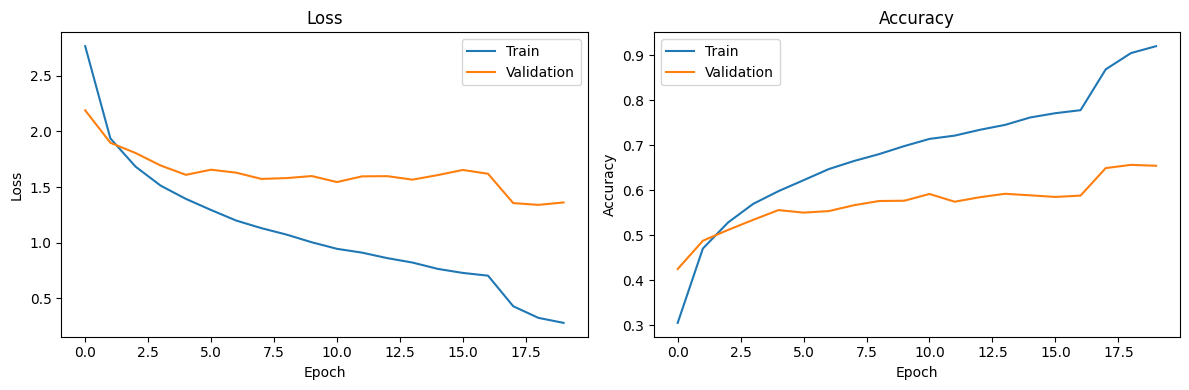

In [9]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    dataset_size = len(dataloader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

# Evaluate on the test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion)

Test Loss: 1.3554 Test Acc: 0.6555


In [11]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)

# Create a DataFrame from the metrics
rows = []
for cls_str, vals in report.items():
    if cls_str.isdigit():
        i = int(cls_str)
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        rows.append({
            'class': i,
            'class_name': class_names[i] if i < len(class_names) else f"Class {i}",
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn,
            'Precision': vals['precision'],
            'Recall': vals['recall'],
            'F1-score': vals['f1-score']
        })

df_metrics = pd.DataFrame(rows).sort_values('class').reset_index(drop=True)
print(df_metrics.head(10))  # Show first 10 classes

# Overall Accuracy
overall_acc = np.trace(cm) / cm.sum()
print(f"\nOverall Test Accuracy: {overall_acc:.4f}")

   class     class_name  TP  FP  FN    TN  Precision  Recall  F1-score
0      0          apple  83  10  17  9890   0.892473    0.83  0.860104
1      1  aquarium_fish  78  18  22  9882   0.812500    0.78  0.795918
2      2           baby  51  45  49  9855   0.531250    0.51  0.520408
3      3           bear  41  43  59  9857   0.488095    0.41  0.445652
4      4         beaver  51  57  49  9843   0.472222    0.51  0.490385
5      5            bed  71  35  29  9865   0.669811    0.71  0.689320
6      6            bee  75  37  25  9863   0.669643    0.75  0.707547
7      7         beetle  64  38  36  9862   0.627451    0.64  0.633663
8      8        bicycle  80  22  20  9878   0.784314    0.80  0.792079
9      9         bottle  72  14  28  9886   0.837209    0.72  0.774194

Overall Test Accuracy: 0.6555


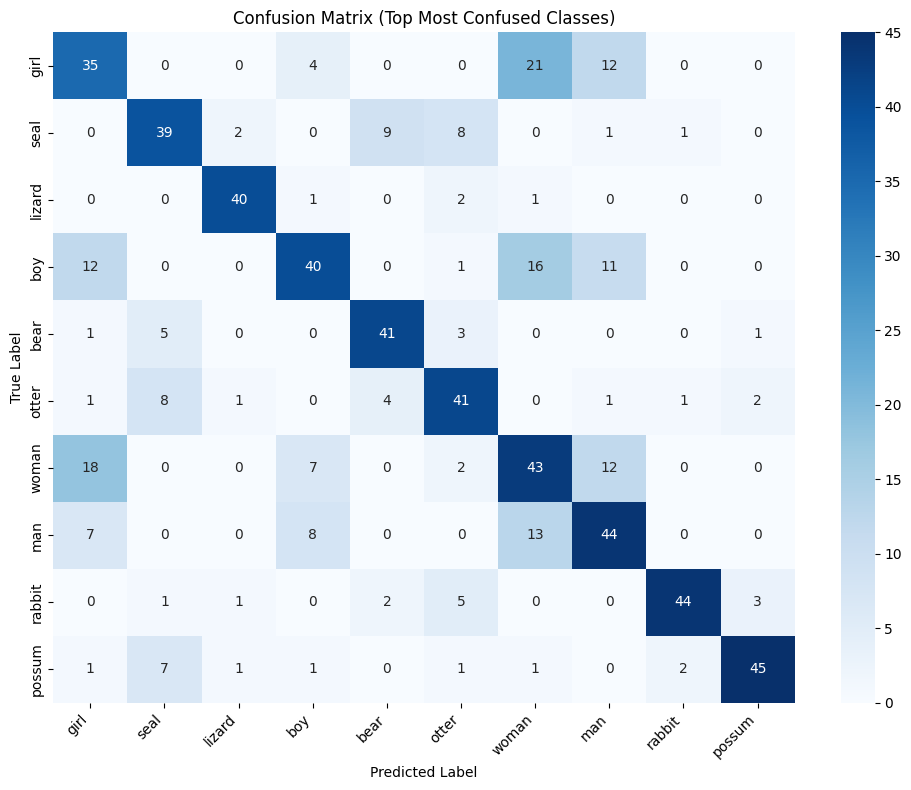

In [12]:
# Plot confusion matrix for top classes (too many classes to show all 100)
plt.figure(figsize=(10, 8))
top_n_classes = 10  # Show top 10 classes

# Get indices of the most confused classes
class_accuracies = [cm[i,i]/cm[i,:].sum() for i in range(len(cm))]
indices = np.argsort(class_accuracies)[:top_n_classes]  # Get indices of lowest accuracy classes

# Create a subset of the confusion matrix
cm_subset = cm[np.ix_(indices, indices)]
class_names_subset = [class_names[i] for i in indices]

# Plot
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_subset, yticklabels=class_names_subset)
plt.title('Confusion Matrix (Top Most Confused Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

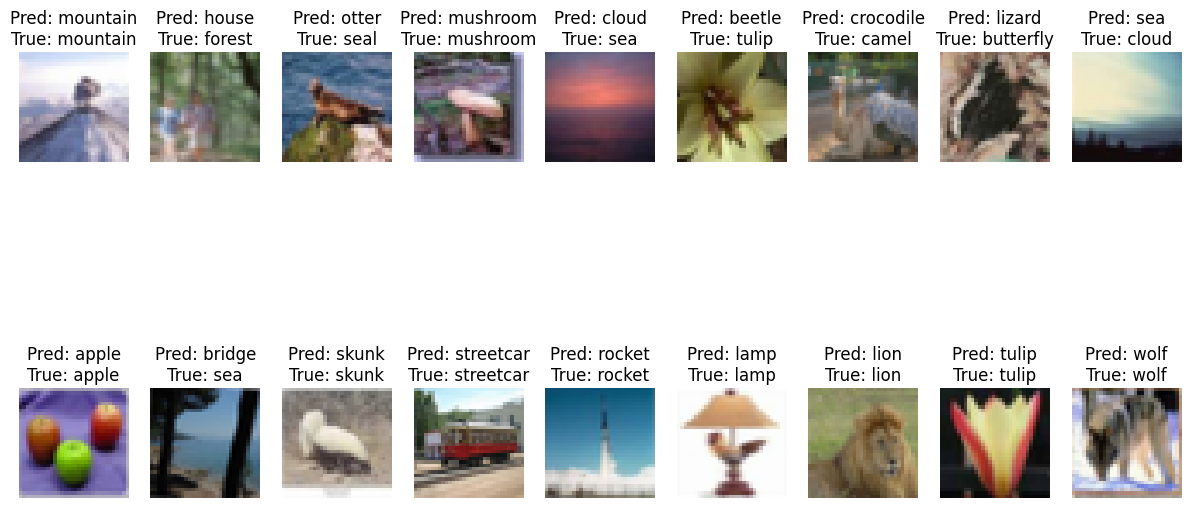

In [13]:
# Display some example predictions
def show_predictions(model, dataloader, class_names, num_images=8):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return
                
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                
                # Convert image for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                # Denormalize
                img = img * np.array(cifar100_std) + np.array(cifar100_mean)
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
    
    plt.tight_layout()
    plt.show()

# Show sample predictions
show_predictions(model, test_loader, class_names, num_images=18)